In [1]:
# Adding the neccecary imports to our code
import numpy as np
import matplotlib.pyplot as plt
import pydot # conda install pydot
from data_structures import SEdge,FVertex,FSGraph
from sklearn.manifold import MDS,TSNE



In [2]:
#type of data:
url_Les_Miserables_network  = '../data/LesMiserables.dot'
url_Rome_graph  = '../data/rome.dot'
url_Jazz_Network  = '../data/JazzNetwork.dot'
url_Small_Directed_Network  = '../data/noname.dot'
url_Pro_League_Network  = '../data/LeagueNetwork.dot'
url_Argumentation_network  = '../data/devonshiredebate_withclusters.dot'
url_Argumentation_network_for_part_five = '../data/devonshiredebate_withonlytwoclusters.dot'
url_Political_blogosphere_network  = '../data/polblogs.dot'
url = url_Jazz_Network

In [3]:
def create_custom_graph(G): # O(V) + O(E) + O(V) + O(E) = O(2V + 2E) = O(V + E)
    # Parsing the vertices and edges from the generated graph into lists
    vertices = [n.get_name() for n in G.get_node_list()] # O(V)

    edges = [(edge.get_source(),edge.get_destination(),edge.get_attributes()) for edge in G.get_edge_list()] # O(E)
    graph = FSGraph()
    for vertex in vertices: # O(V)
      vertex = FVertex(vertex, 0, 0)  # Initialize the vertex with ID and default coordinates
      graph.add_vertex(vertex)

    for edge in edges: # O(E)
        w=0
        if ("JazzNetwork" not in url):
             w = list(edge[2].values())[0].strip("\"")
        if (float(w)<1.0 or float(w)>3.0) and ("LeagueNetwork" in url): # because only prolegue needs fltering
            continue
        source_vertex = graph.get_vertex(edge[0])
        neighbor_vertex = graph.get_vertex(edge[1])
        if source_vertex is None:
            source_vertex = FVertex(edge[0], 0, 0)
        if neighbor_vertex is None:
            neighbor_vertex = FVertex(edge[1], 0, 0)
        source_vertex.add_neighbor(neighbor_vertex)
        source_vertex.add_children(neighbor_vertex)
        neighbor_vertex.add_parents(source_vertex)
        graph.add_edge(SEdge(source_vertex, neighbor_vertex,float(w)))
    if ("JazzNetwork" in url) : # as the jazz network don't have weight initialise jazz network edges weight with 1
        for edge in graph.edges:
            edge.weight = 1.0
    return graph

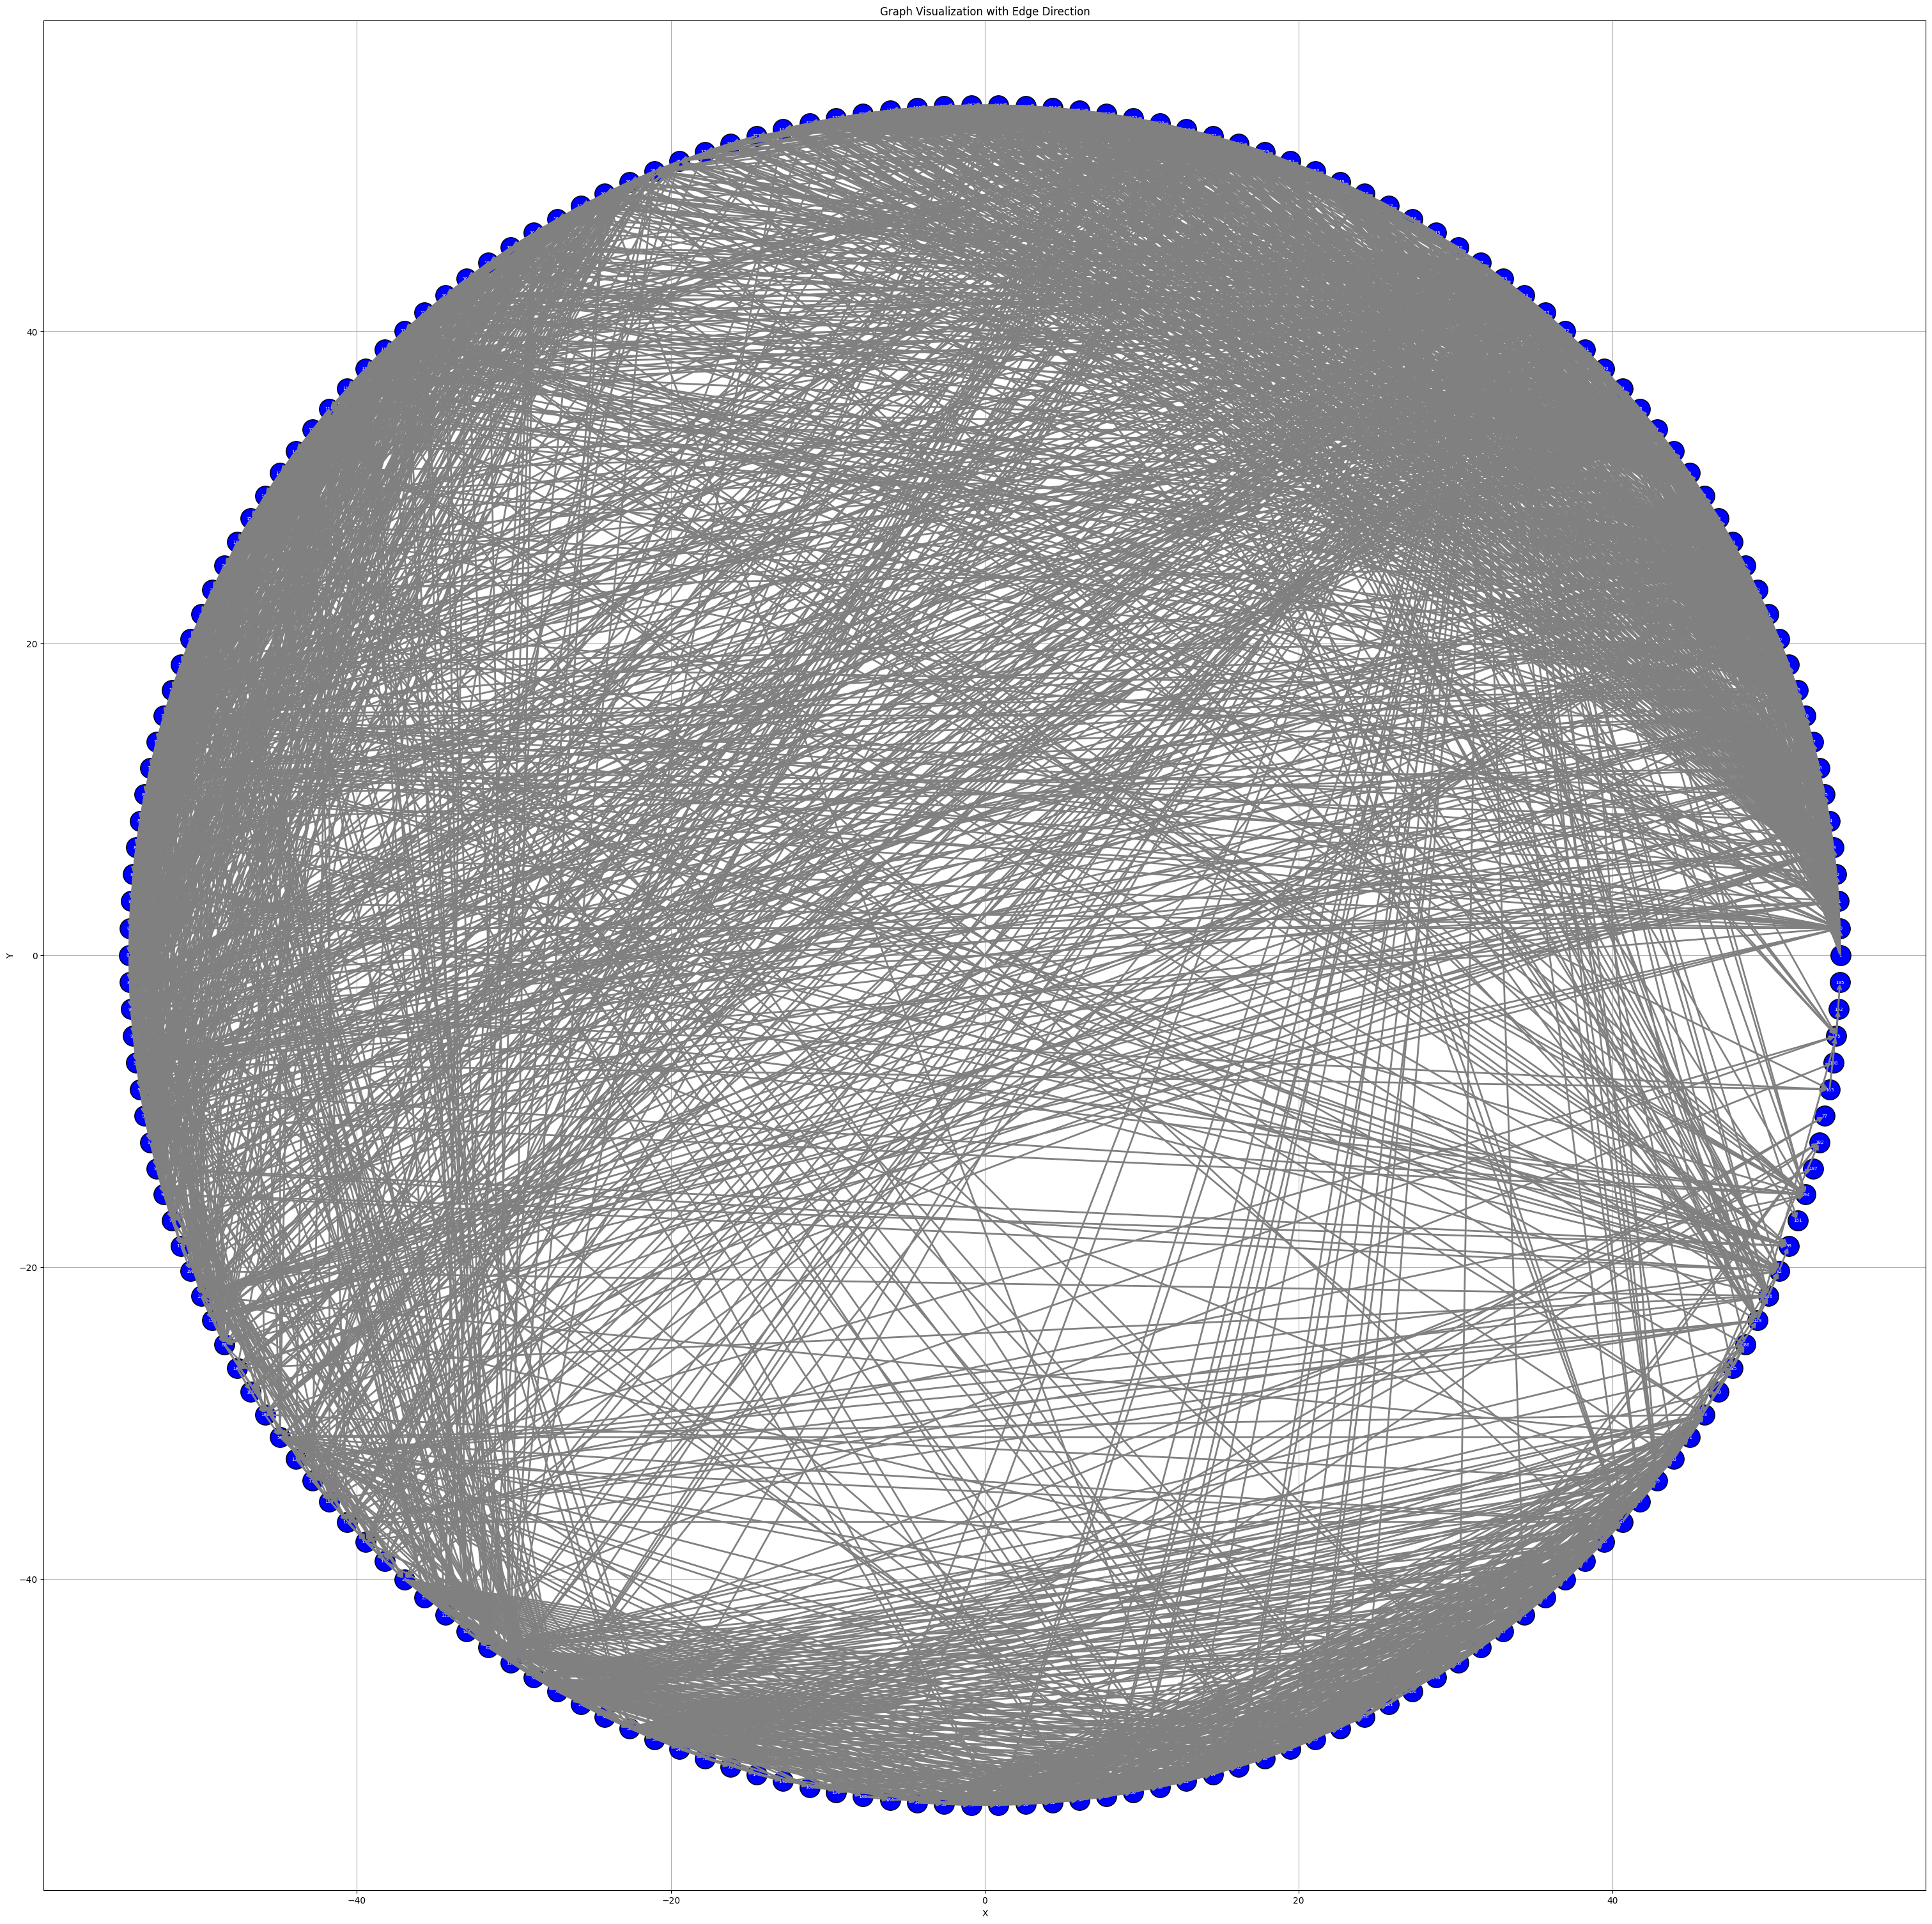

In [4]:
# Parsing the data from the dot file:
G = pydot.graph_from_dot_file(url)[0]
#Convering the graph into our custom graph
graph = create_custom_graph(G) #O(V) + O(E) = O(V + E)
# Visualize the graph

fig_size=5+len(graph.vertices)/6 # new line
radius=5+len(graph.vertices)/4 # new line

graph.visualize_graph(fig_size,radius) #O(V + E)


In [5]:
def floyd_warshall(G):

  D_array = np.full((len(G.vertices), len(G.vertices)), np.inf)

  for edge in G.edges:
      D_array[int(edge.start.id)-1][int(edge.end.id)-1] = int(edge.weight)
      D_array[int(edge.end.id)-1][int(edge.start.id)-1] = int(edge.weight)

  for v in G.vertices.values():
    D_array[int(v.id)-1][int(v.id)-1] = 0

  for k in G.vertices.values():
    for i in G.vertices.values():
      for j in G.vertices.values():
        k_idx = int(k.id) - 1
        i_idx = int(i.id) - 1
        j_idx = int(j.id) - 1

        if D_array[i_idx][j_idx] > D_array[i_idx][k_idx] + D_array[k_idx][j_idx]:
          D_array[i_idx][j_idx] = D_array[i_idx][k_idx] + D_array[k_idx][j_idx]

  return(D_array)

for v in graph.vertices.values():
  if v.id == '"\n"':
      graph.vertices.remove(v)

D_array = floyd_warshall(graph)
D_array3 = floyd_warshall(graph)
print(D_array)

[[0. 1. 1. ... 4. 4. 4.]
 [1. 0. 2. ... 3. 3. 3.]
 [1. 2. 0. ... 3. 3. 3.]
 ...
 [4. 3. 3. ... 0. 3. 4.]
 [4. 3. 3. ... 3. 0. 4.]
 [4. 3. 3. ... 4. 4. 0.]]


In [6]:
def projection_visualization(X_tranformed, vertices, edges):

    plt.figure(figsize=(8, 6))
    for i, vertex in enumerate(vertices):
        plt.scatter(X_transformed[i, 0], X_transformed[i, 1], color='blue')
        plt.text(X_transformed[i, 0], X_transformed[i, 1], f'{vertex.id}', fontsize=9)

    for edge in edges:
        plt.plot([edge.start.x, edge.end.x], [edge.start.y, edge.end.y], color='gray', alpha=0.5)


    plt.title('MDS Visualization using  Jazz network with eps = 0.0000001 ')
    plt.grid(False)
    plt.axis('off')
    plt.show()

Convergences: 7857.364690747788
Best_iter: 400


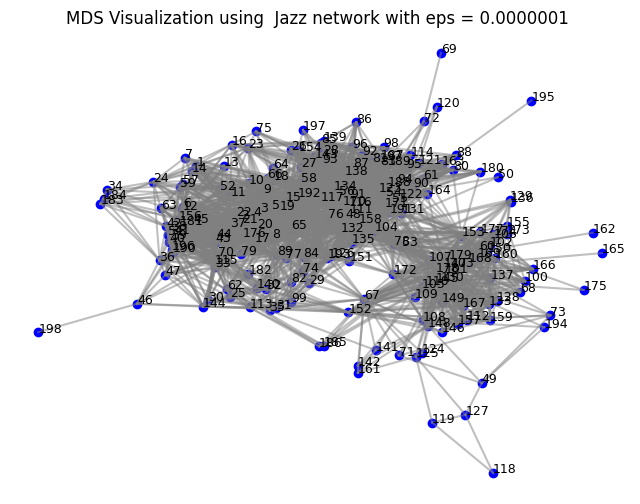

In [7]:
#Apply MDS

mds = MDS(n_components=2, dissimilarity='precomputed', max_iter = 400, eps = 0.0000001, normalized_stress='auto')
X_transformed = mds.fit_transform(D_array)

for i in range(len(X_transformed)):
  for v in graph.vertices.values():
    if v.id == str(i+1):
      v.x = X_transformed[i][0]
      v.y = X_transformed[i][1]

convergences = mds.stress_
print("Convergences:", convergences)
print("Best_iter:", mds.n_iter_)

projection_visualization(X_transformed, graph.vertices.values(), graph.edges)

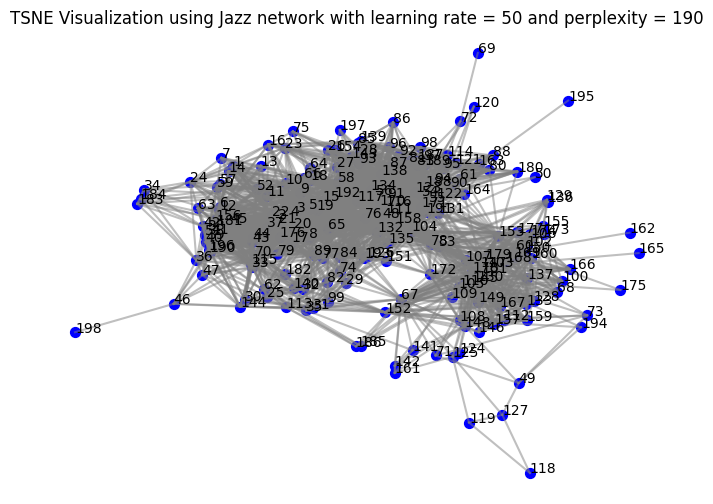

KL Divergence: 0.011954094283282757
Number of iterations: 799
learning rate 50


In [8]:
#Apply t-SNE
# Visualize the embedded points
def visualize_TSNE(X_transformed, vertices, edges):

    plt.figure(figsize=(8, 6))
    plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c='b', s=50)
    for i, vertex in enumerate(vertices):
        plt.text(X_transformed[i, 0], X_transformed[i, 1], str(vertex.id))

    for edge in edges:
        plt.plot([edge.start.x, edge.end.x], [edge.start.y, edge.end.y], color='gray', alpha=0.5)
    plt.title('TSNE Visualization using Jazz network with learning rate = 50 and perplexity = 190' )
    plt.grid(False)
    plt.axis('off')
    plt.show()

tsne = TSNE(n_components=2,init="random",metric="precomputed", perplexity = 190, n_iter = 5000, learning_rate = 50  ,min_grad_norm = 0.0000000001)
X_transformed1 = tsne.fit_transform(D_array3)

for i in range(len(X_transformed)):
  for v in graph.vertices.values():
    if v.id == str(i+1):
      v.x = X_transformed[i][0]
      v.y = X_transformed[i][1]

# Visualize the embedded points
visualize_TSNE(X_transformed, graph.vertices.values(), graph.edges )

print("KL Divergence:", tsne.kl_divergence_)
print("Number of iterations:", tsne.n_iter_)
print("learning rate", tsne.learning_rate_)